### Notebook 02: EDA

In [21]:
# Import neccessary support
import pandas as pd
import numpy as np
import cv2, os
import random

import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from zipfile import ZipFile

#import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

# load VGG-16 model: 23 layers, 138,357,544 params, 528MB
from keras.applications.vgg16 import VGG16
# These models expect 
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.utils.vis_utils import plot_model

In [2]:
# Load Image ID's from text file
with open('../data/dog_data_part2.txt', 'r') as imagehandles:
    # Store Image ID's as variable for image pre-processing, removing the endline character in the process
    dog_data_part2 = [image_id[:-1] for image_id in imagehandles]
# Check that all is copacetic
len(dog_data_part2), type(dog_data_part2), dog_data_part2[0], type(dog_data_part2[0])

(1240, list, '2377385', str)

In [3]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [4]:
# Sometimes my tensorflow tries to use GPU support but I don't want it to, have had many errors.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
#tf.compat.v1.Session(), .compat.v1.
sess_cpu = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(device_count={'GPU': 0}))
print(tf.__version__)
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

2.3.1
Please install GPU version of TF


In [5]:
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


### Instantiate VGG-16 Model<br>
>  Image data format: Set in Keras JSON config file<br>
> - Stored at  '~/.keras/keras.json'<br>
{<br>
    "floatx": "float32",<br>
    "epsilon": 1e-07,<br>
    "backend": "tensorflow",<br>
    "image_data_format": "channels_last"<br>
}<br><br>
- NOTE: "Channels Last = (height, width, depth)-TensorFlow data format convention<br>

#### Vizualize filters and feature maps of CNNs with VGG-16

In [6]:
# load VGG-16 model: 23 layers, 138,357,544 params, 528MB
from keras.applications.vgg16 import VGG16

# Adjust input size of the model for include_top=False
# new_input = Input(shape=(224,224,3)) --> MUST INCLUDE THIS PARAM AFTER CLASSIFICATION

# load the model weights into memory
# https://keras.io/api/applications/vgg/#vgg16-function
model_vgg16 = VGG16(weights='imagenet')
#model_vgg16 = VGG16(
#                include_top=True,   # include_top=False to load model wihtout the fully-connected output layers used to make predictions
#                weights='imagenet', # Weights are downloaded automatically when instantiating a model: Keras Applications ~/.keras/models/
#                input_tensor=None,  # input_tensor = new_input = Input(shape=(224,224,3))
#                input_shape=None,
#                pooling=None,
#                classes=1000,
#                classifier_activation="softmax"
#            )
# Summarize the loaded model with all layers (include_top=True)
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Filter Summary (by network layer)

In [7]:
# VGG-16 Layers with non-zero parameters
layers_VGG16 = [ 1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17, 20, 21, 22 ]
# Choose a layer to perform feature extraction
layer_VGG16  = 0
# summarize filter shapes
print('Layer Summary\tKernel Size: ( K x K )\t')
print()
print('Number\t\tName\t\t(K, K, Depth, Nodes)')
# Loop thru each layer in ImageNet Model to summarize
for layer in model_vgg16.layers:
    # check for convolutional layer
    if ('conv' not in layer.name) & ('fc' not in layer.name):
        layer_VGG16 += 1
        continue # Exclude fully connected layers & return to loop beginning
    # get filter weights
    filters, biases = layer.get_weights()
    print(f'Layer {layer_VGG16}:\t{layer.name}\t{filters.shape}')
    layer_VGG16 += 1
print()

# Select layer from VGG-16 layers list above to retrieve weights
layer_number = layers_VGG16[0]
# Retrieve current weights from selected hidden layer: 'layer_number'
# Weights rep state of layer, get_weights loads state into similarly parameterized layers
filters_extract, biases_extract = model_vgg16.layers[layer_number].get_weights()
print(f'Layer {layer_number}: {filters_extract.shape}')

Layer Summary	Kernel Size: ( K x K )	

Number		Name		(K, K, Depth, Nodes)
Layer 1:	block1_conv1	(3, 3, 3, 64)
Layer 2:	block1_conv2	(3, 3, 64, 64)
Layer 4:	block2_conv1	(3, 3, 64, 128)
Layer 5:	block2_conv2	(3, 3, 128, 128)
Layer 7:	block3_conv1	(3, 3, 128, 256)
Layer 8:	block3_conv2	(3, 3, 256, 256)
Layer 9:	block3_conv3	(3, 3, 256, 256)
Layer 11:	block4_conv1	(3, 3, 256, 512)
Layer 12:	block4_conv2	(3, 3, 512, 512)
Layer 13:	block4_conv3	(3, 3, 512, 512)
Layer 15:	block5_conv1	(3, 3, 512, 512)
Layer 16:	block5_conv2	(3, 3, 512, 512)
Layer 17:	block5_conv3	(3, 3, 512, 512)
Layer 20:	fc1	(25088, 4096)
Layer 21:	fc2	(4096, 4096)

Layer 1: (3, 3, 3, 64)


In [26]:
filters_extract

array([[[[0.8601116 , 0.6161919 , 0.55114007, ..., 0.4212452 ,
          0.4828852 , 0.5304859 ],
         [0.9545779 , 0.5408773 , 0.6017826 , ..., 0.4582953 ,
          0.4846108 , 0.5538601 ],
         [0.89960235, 0.3896376 , 0.5539096 , ..., 0.42523453,
          0.4852669 , 0.5518304 ]],

        [[0.81635594, 0.65118545, 0.52590066, ..., 0.4087713 ,
          0.340725  , 0.47531587],
         [0.8683965 , 0.5615535 , 0.5647105 , ..., 0.44733417,
          0.2931476 , 0.46953422],
         [0.8437643 , 0.39145148, 0.5206881 , ..., 0.42896524,
          0.30857468, 0.4940327 ]],

        [[0.47662497, 0.63058364, 0.43417358, ..., 0.4150598 ,
          0.22949417, 0.28977698],
         [0.4609779 , 0.5572666 , 0.4450579 , ..., 0.4508793 ,
          0.12949093, 0.22478487],
         [0.4736674 , 0.40397066, 0.41671643, ..., 0.42346177,
          0.16341406, 0.27143562]]],


       [[[0.7392438 , 0.6404719 , 0.6507926 , ..., 0.43525034,
          0.810127  , 0.7901605 ],
         [0.

In [8]:
# (kernel-height, kernel-width, channel-depth, No. of filters)
# 64-filters each (3 x 3 x 3) 3D volume, cubic filters
filters_extract.shape, type(filters_extract)

((3, 3, 3, 64), numpy.ndarray)

In [9]:
filters_extract[0][0].shape, filters_extract.min(3),

((3, 64),
 array([[[-0.36283946, -0.48702785, -0.45139903],
         [-0.39102998, -0.495031  , -0.46935585],
         [-0.3776668 , -0.50566256, -0.4622438 ]],
 
        [[-0.37709406, -0.4805826 , -0.44129026],
         [-0.43290257, -0.46505883, -0.43076617],
         [-0.51870257, -0.67140007, -0.6122331 ]],
 
        [[-0.38299575, -0.48918396, -0.45314637],
         [-0.40317345, -0.5517545 , -0.46822482],
         [-0.38670486, -0.5010919 , -0.45361367]]], dtype=float32))

In [10]:
 filters_extract.max(3)

array([[[0.42947057, 0.55037946, 0.4800154 ],
        [0.50021327, 0.6085159 , 0.5649865 ],
        [0.42510888, 0.57510966, 0.51294214]],

       [[0.36549452, 0.43711686, 0.40405855],
        [0.48986775, 0.52829504, 0.5055312 ],
        [0.44455817, 0.5295403 , 0.4862477 ]],

       [[0.32685903, 0.4086302 , 0.37457848],
        [0.459542  , 0.53946865, 0.5184412 ],
        [0.40483335, 0.454858  , 0.40707463]]], dtype=float32)

#### Visualize Second Layer (First Conv2D Layer immediately following the input layer)

	Layer 1:  FILTER #


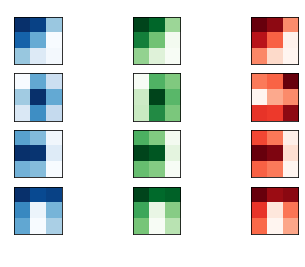

In [11]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters_extract.min(), filters_extract.max()
# Sets the minimum to zero and the maximum to one
filters_extract = (filters_extract - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 4, 1
for i in range(n_filters):
    # get the filter
    f = filters_extract[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        if j == 0:
            c = '\nBLUE'
            color_map = 'Blues'
        elif j == 1:
            c = '\nGREEN'
            color_map = 'Greens'
        else:
            c ='\nRED'
            color_map = 'Reds'
        ax = plt.subplot(n_filters, 3, ix, fc='grey')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.xlabel(xlabel=c,color='w')
        plt.ylabel(ylabel=f'  \n\n{i+1}',color='w',rotation=0)
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap=color_map)
        ix += 1
#print('\t\t FILTER #')
print(f'\tLayer {layer_number}:  FILTER #')

#### Test Visual Genome Dog Data, chosen at random, on VGG-16 Loaded Weights

In [25]:
# NOTICE, SOME CODE IN THIS CELL FROM:
# https://thispointer.com/python-how-to-get-the-list-of-all-files-in-a-zip-archive/

# Input shape acrandom_dogby VGG-16 = 224 x 224 x3
img_height = 224
img_width = 224

# Choose a dog randomly to test breed accuracy
dog_pic_x = random.randint(0, len(dog_data_part2)-1)
random_dog = int(dog_data_part2[dog_pic_x])

# ~5.5 GB ZIP Archive, 40% of total data set
# Open, read, and close ZIP file for faster image pre-processing
with ZipFile('../../visual_genome_part2.zip', "r") as z:
    # One file in zip archive
    VG_100K_2 = z.namelist()

    # Iterate over image file names, 'VG_100K_2/image_id.jpg'
    for ith_image in VG_100K_2: 
        # Get extension of file, '.jpg'
        ext = os.path.splitext(ith_image)[-1]
        # Get root of file, root = VG_100K_2/image_id.jpg
        root = os.path.splitext(ith_image)[0]
        
        # Skip over Archive Directory
        if (ext == ".jpg"):
            
            # Skip root[:10]='VG_100K_2' in dog_pic_ids
            if int(root[10:]) == random_dog:
                
                # Read image binary data of 'VG_100K_2' from zip archive('visual_genome_part2.zip')
                in_bytes = z.read(ith_image) # VG_100K_2/
                # Decode bytes to image
                img = cv2.imdecode(np.frombuffer(in_bytes, np.uint8), cv2.IMREAD_COLOR)
                # Input shape accepted by VGG-16 = 224 x 224 x3
                img = cv2.resize(img, dsize=(img_width, img_height))
                # Convert a PIL image instance to a Numpy array
                dog_x = image.img_to_array(img)
                # Expand the shape of the array: Insert new axis at 'axis' position in expanded array shape
                dog_x = np.expand_dims(dog_x, axis=0)
                # Returns array with type: 'float32', covert: RGB --> BGR, & zero-center each channel wrt ImageNet dataset
                # i.e. subtract mean RGB value, computed on Train set, from each pixel
                dog_x = preprocess_input(dog_x)
                
                # Extract features from image_id = dog_x with VGG-16
                # Get a prediction: Probability dog_x image belongs to each of the 1,000 object types from ImageNet
                preds = model_vgg16.predict(dog_x)

                # Decode extracted features into class, description, and probability
                # Converts probabilities to class labels
                preds_class_breed_score = decode_predictions(preds, top=5)[0]
                
                # Display the prediction corresponding to the image
                print(f'Prediction: (for random dog = {random_dog}) \n')
                for i in range(len(preds_class_breed_score)):
                    print(f'\t{preds_class_breed_score[i][2]*100:.2f}%\t:{preds_class_breed_score[i][1]}')

                # Output img with window name as 'image' 
                cv2.imshow('img', img)
                
                # Display for 30 secs = 1_000ms * 30
                #cv2.waitKey(30*1000)
                
                # Display image indefinitely
                cv2.waitKey(0)

cv2.destroyAllWindows()

Prediction: (for random dog = 2392123) 

	11.39%	:maze
	8.13%	:swimming_trunks
	5.47%	:swing
	4.15%	:fountain
	3.22%	:snorkel


In [13]:
## model.save('/../assets/model.h5')

print("Saved model to disk")
#del model

Saved model to disk


In [23]:
img_path = '../../visual_genome_part2/VG_100K_2/2405343.jpg'
img = image.load_img(img_path, target_size=(224, 224))
dog_x = image.img_to_array(img)
dog_x = np.expand_dims(dog_x, axis=0)
dog_x = preprocess_input(dog_x)

# Extract features from image_id = dog_x with VGG-16
# Get a prediction: Probability dog_x image belongs to each of the 1,000 object types from ImageNet
preds = model_vgg16.predict(dog_x)

# Decode extracted features into class, description, and probability
# Specifically, converts probabilities to class labels
preds_class_breed_score = decode_predictions(preds, top=25)[0] # top = n returns top-n most likely classes for given image
print('Prediction: \n')
for i in range(len(preds_class_breed_score)):
    print(f'\t{preds_class_breed_score[i][2]*100:.2f}%\t:{preds_class_breed_score[i][1]}')

Prediction: 

	37.11%	:keeshond
	13.47%	:schipperke
	8.45%	:Newfoundland
	7.30%	:groenendael
	6.35%	:Norwegian_elkhound
	3.85%	:indri
	3.57%	:skunk
	3.21%	:Tibetan_mastiff
	1.63%	:German_shepherd
	1.08%	:Bouvier_des_Flandres
	0.93%	:Border_collie
	0.93%	:malamute
	0.68%	:Siberian_husky
	0.64%	:fur_coat
	0.48%	:flat-coated_retriever
	0.47%	:chow
	0.47%	:kelpie
	0.45%	:Pomeranian
	0.44%	:Leonberg
	0.42%	:Eskimo_dog
	0.29%	:timber_wolf
	0.27%	:American_black_bear
	0.24%	:bearskin
	0.19%	:llama
	0.18%	:Scottish_deerhound


In [20]:
type(preds), len(preds)

(numpy.ndarray, 1)

In [22]:
# Creates an unneccessary plot of VGG-16 Model Layers, will install and check-out if there's time
plot_model(model_vgg16, to_file='../images/vgg16.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
BASEPATH1 = '../../visual_genome_part1/VG_100K_1/'
BASEPATH2 = '../../visual_genome_part2/VG_100K_2/'

LABELS = set()

paths = []
    
for d in os.listdir(BASEPATH2):
    LABELS.add(int(d[:-4]))
    paths.append((BASEPATH2+d, int(d[:-4])))

In [ ]:
# resizing and converting to RGB
def load_and_preprocess_image(path):
    image = cv2.imread(path)
    image = cv2.resize(image, (224,224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [130]:
os.listdir('../../visual_genome_part2/VG_100K_2/');

In [131]:
paths[0][0]

'../../visual_genome_part2/VG_100K_2/1.jpg'

In [132]:
len(paths)

43733

In [ ]:
X = []
y = []

for path, label in paths:
    #for image_path in os.listdir(path):
    image = load_and_preprocess_image(path)
    X.append(image)
    y.append(label)

In [125]:
path

'../../visual_genome_part2/VG_100K_2/2378352.jpg'

In [127]:
image

array([[[196, 203, 226],
        [196, 202, 226],
        [198, 204, 225],
        ...,
        [160, 170, 203],
        [161, 170, 204],
        [163, 173, 204]],

       [[201, 206, 225],
        [211, 215, 233],
        [218, 223, 235],
        ...,
        [161, 169, 205],
        [162, 170, 206],
        [161, 170, 203]],

       [[222, 225, 236],
        [213, 216, 234],
        [204, 207, 228],
        ...,
        [160, 168, 204],
        [163, 169, 203],
        [167, 173, 205]],

       ...,

       [[ 70,  69,  34],
        [ 77,  78,  37],
        [ 82,  79,  37],
        ...,
        [ 77,  82, 102],
        [ 76,  79, 100],
        [ 68,  74,  94]],

       [[ 82,  78,  40],
        [ 83,  82,  38],
        [ 86,  83,  37],
        ...,
        [ 73,  78,  98],
        [ 72,  78,  98],
        [ 66,  72,  92]],

       [[ 87,  83,  44],
        [ 80,  78,  36],
        [ 76,  73,  36],
        ...,
        [ 75,  80, 100],
        [ 71,  78,  97],
        [ 65,  71,  93]]

In [122]:
paths.index((path,label))

2437

In [66]:
len(X), X[0].shape

(1443, (224, 224, 3))

In [103]:
len(LABELS), len(X)

(43903, 1443)

In [ ]:
encoder = LabelBinarizer()
X = np.array(X)
y = encoder.fit_transform

In [77]:
# Replace image label with dog tag or zero
for image_label in y:
    #search for the item
    y_position = y.index(image_label)
    # Check if dog or not
    if image_label in dog_data_part2:
        #search for the item
        y_position = y.index(image_label)
        # Label dog images with ones
        y[y_position] = 1
    else:
        y[y_position] = 0

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [76]:
set(y)

{0}

In [71]:


print('The index of', item, 'in the list is:', index)

set

In [111]:
y;